In [1]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

Using TensorFlow backend.


In [2]:
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

In [3]:
tokens = ['0','1','2', '3','4','5','6','7','8','9','(',')', '+', '-', '*', 'N']

# 准备数据

### 加载图片

In [4]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(path+'/image_contest_level_1', 
                                  batch_size=1, 
                                  target_size=(30,90),
                                  shuffle=False,
                                  class_mode=None,
                                  color_mode='grayscale'
                                 )


Found 100000 images belonging to 1 classes.


In [5]:
#imgs = np.concatenate([batches.next() for i in range(batches.nb_sample)])

imgs = load_array(path+'imgs0.dat')   #一般直接加载保存好的数据，快速加载

### 处理标签

In [6]:
x2label_idx = [int(f[8:][:-4]) for f in batches.filenames]
label_texts = []
lines = []
with open(path+'labels.txt') as f:
    lines = f.readlines()
label_texts = [l.strip().split()[0].ljust(7, 'N') for l in lines]
token2idx={char:i for i, char in enumerate(tokens)}
labels = np.array([[token2idx[token] for token in ts] for ts in label_texts])

### 8-2划分测试集 验证集

In [7]:
idxs = np.random.permutation(imgs.shape[0])
mask = np.random.rand(len(imgs)) < 0.6
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]

x_trn = imgs[trn_idxs]
y_trn = labels[np.array(x2label_idx)[trn_idxs]]

x_val = imgs[val_idxs]
y_val = labels[np.array(x2label_idx)[val_idxs]]


# 训练

In [8]:
def map2seq(x):
    return K.reshape(K.permute_dimensions(x, (0, 3, 2, 1)), (x.shape[0], x.shape[-1], -1))

In [9]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[-1], shape[1]*shape[2])

In [10]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [11]:
def trn_gen(batch_size):
    da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03)
    x_trn_len = len(x_trn)//64*64
    trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)
    while True:
        input_length = np.zeros([batch_size, 1]) + 17
        label_length = np.zeros([batch_size, 1])
        x, y = next(trn_batches)
        for i in range(batch_size):
            if y[i][6] == 15:  #如果最后一个字符是N
                label_length[i] = 5
                y[i][5] = 0
                y[i][6] = 0
            else:
                label_length[i] = 7
        yield [x, y, input_length, label_length], np.zeros([batch_size])

In [12]:
def val_data():
    size = len(x_val)
    input_length = np.zeros([size, 1]) + 17
    label_length = np.zeros([size, 1])
    for i in range(size):
        if y_val[i][6] == 15:  #如果最后一个字符是N
            label_length[i] = 5
            y_val[i][5] = 0
            y_val[i][6] = 0
        else:
            label_length[i] = 7
    return [x_val, y_val, input_length, label_length], np.zeros([size])

In [ ]:
img = trn_gen(64)[0][0][0]
plot(img.reshape(30,90))
(val_data()[0][1][0], val_data()[0][2][0], val_data()[0][3][0])

In [ ]:
t_data = next(trn_gen(1))[0]
img = t_data[0][0]
plot(img.reshape(30,90))
(t_data[1][0], t_data[2][0], t_data[3][0])

In [19]:
input_shape=(1, 30, 90)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization(axis=1)
inner = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(input_data)
inner = MaxPooling2D()(inner)
inner = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(inner)
inner = MaxPooling2D()(inner)
inner = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(inner)
inner = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(inner)
inner = MaxPooling2D((2,1))(inner)
inner = Convolution2D(512, 3, 3,border_mode='same', activation='relu')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = Convolution2D(512, 3, 3, border_mode='same', activation='relu')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D((2,1))(inner)

inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)

inner = Bidirectional(GRU(256, return_sequences=True), merge_mode='sum')(inner)
inner = Bidirectional(GRU(256, return_sequences=True), merge_mode='concat')(inner)
y_pred = Dense(16, activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(7,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

In [13]:
input_shape=(1, 30, 90)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization(axis=1)

inner = Convolution2D(32, 3, 3,  activation='relu')(input_data)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(64, 3, 3,  activation='relu')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(128, 3, 3, activation='relu')(inner)
inner = BatchNormalization(axis=1)(inner)
inner = MaxPooling2D((2,1))(inner)

inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)

inner = Dropout(0.5)(inner)
inner = Dense(32, activation='relu')(inner)
inner = BatchNormalization(axis=1)(inner)

inner = Dropout(0.5)(inner)
inner = Bidirectional(GRU(128, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)
#y_pred = TimeDistributed(Dense(16, activation='softmax'))(inner)

inner = Dropout(0.5)(inner)
y_pred = Dense(16, activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(7,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)

In [ ]:
model.summary()


In [14]:
def evaluate(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        pred = []
        for o in out_best:
            if o != 15:
                pred.append(o)
        if len(pred) < 7:
            for i in range(7-len(pred)): pred.append(0) 
        equal = np.array_equal(pred, y_test[j])
        if equal: correct_number=correct_number+1
    return correct_number/batch_num

In [15]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print(' acc: %f%%'%acc)

evaluator = Evaluate()

In [16]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam())


In [ ]:
x_trn_len = len(x_trn)//64*64
x_val_len = len(x_val)//64*64

model.fit_generator(trn_gen(64), x_trn_len, nb_epoch=50, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)


Epoch 1/50
59968/59968 [==============================] - 599s - loss: 2.4852 - val_loss: 0.9986
Epoch 2/50
59968/59968 [==============================] - 599s - loss: -1.9420 - val_loss: -2.3748
Epoch 3/50
59968/59968 [==============================] - 599s - loss: -2.2305 - val_loss: -2.5263
Epoch 4/50
59968/59968 [==============================] - 598s - loss: -2.3760 - val_loss: 13.8024
Epoch 5/50
59968/59968 [==============================] - 599s - loss: -2.4443 - val_loss: -1.7579
Epoch 6/50
59968/59968 [==============================] - 576s - loss: -2.6846 - val_loss: -2.7998
Epoch 30/50
59968/59968 [==============================] - 575s - loss: -2.6893 - val_loss: -2.7284
Epoch 31/50
59968/59968 [==============================] - 576s - loss: -2.6864 - val_loss: -2.7964
Epoch 32/50
59968/59968 [==============================] - 575s - loss: -2.6887 - val_loss: -0.6099
Epoch 33/50
59968/59968 [==============================] - 575s - loss: -2.6897 - val_loss: -2.5446
Epoch 34

In [ ]:
model.fit_generator(trn_gen(64), x_trn_len, nb_epoch=50, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/50
59776/59776 [==============================] - 581s - loss: -2.7647 - val_loss: 4.8135
Epoch 2/50
59776/59776 [==============================] - 581s - loss: -2.7895 - val_loss: 4.2502
Epoch 3/50
59776/59776 [==============================] - 581s - loss: -2.7911 - val_loss: 4.2959
Epoch 15/50
59776/59776 [==============================] - 582s - loss: -2.7947 - val_loss: 4.2583
Epoch 16/50
59776/59776 [==============================] - 580s - loss: -2.7901 - val_loss: 4.2505
Epoch 17/50
59776/59776 [==============================] - 580s - loss: -2.7988 - val_loss: 4.2433
Epoch 18/50
59776/59776 [==============================] - 581s - loss: -2.7962 - val_loss: 4.5098
Epoch 19/50
59776/59776 [==============================] - 581s - loss: -2.7901 - val_loss: 4.3294
Epoch 20/50
59776/59776 [==============================] - 580s - loss: -2.7971 - val_loss: 4.2473
Epoch 21/50
59776/59776 [==============================] - 581s - loss: -2.7972 - val_loss: 4.2622
Epoch 22/50
5

In [24]:
model.optimizer=0.0001


In [18]:
[X_test, y_test, _, _], _  = val_data()
out = base_model.predict(X_test[:10])
ret = []
for j in range(out.shape[0]):
    out_best = list(np.argmax(out[j, 2:], 1))
    out_best = [k for k, g in itertools.groupby(out_best)]
    outstr = ''.join([tokens[c] for c in out_best])
    ret.append(outstr)

In [19]:
ret

['(4N*N8)N+N8N',
 '(5*N5)+N1N',
 '7N*N9N+N5N',
 '1N*N(8N+N3)N',
 '3-1N+N0N',
 '6N+N(0*N1)N',
 '2N+N7+N1N',
 '9N-(4-9)N',
 '(0*N8)-0N',
 '6N+N9N+N4N']

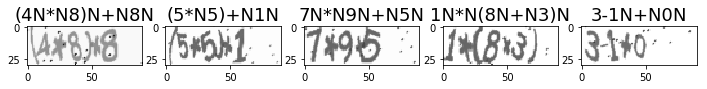

In [20]:
plots(X_test[:5].reshape(-1, 30,90), titles=ret[:5])

In [21]:
evaluate(base_model, batch_num=6400)

0.995

In [ ]:
model.save('gru.h5')

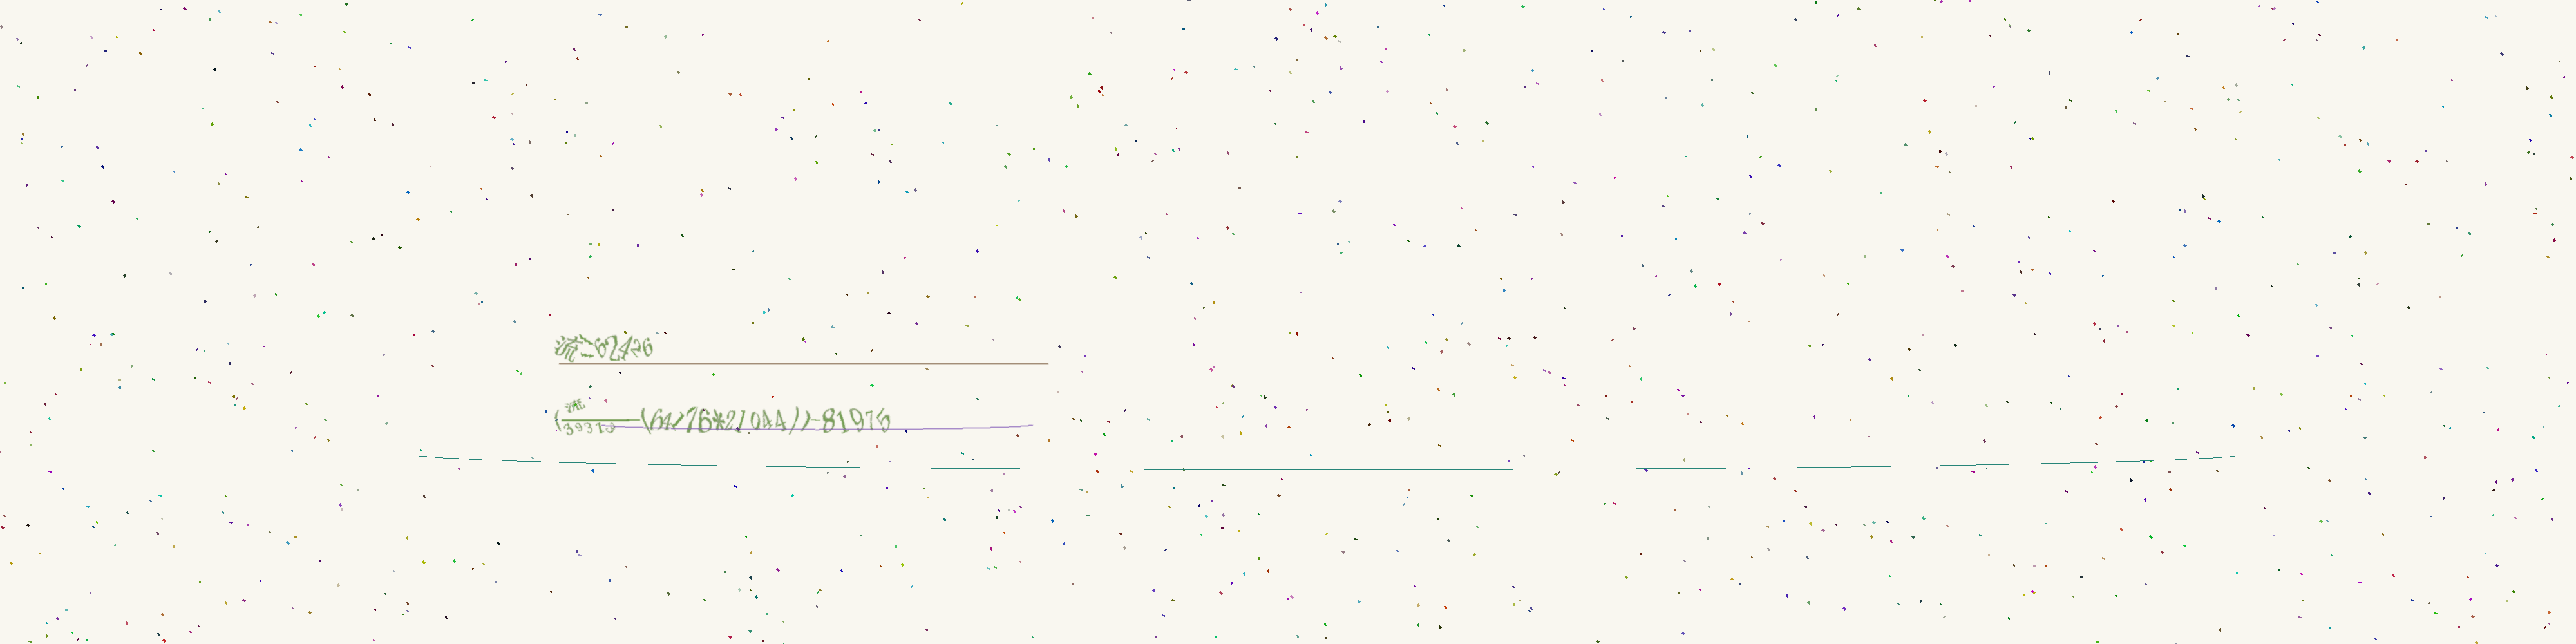

In [2]:
Image.open('data/baidu/image_contest_level_2/10000.png')

In [6]:
??cv2.Canny

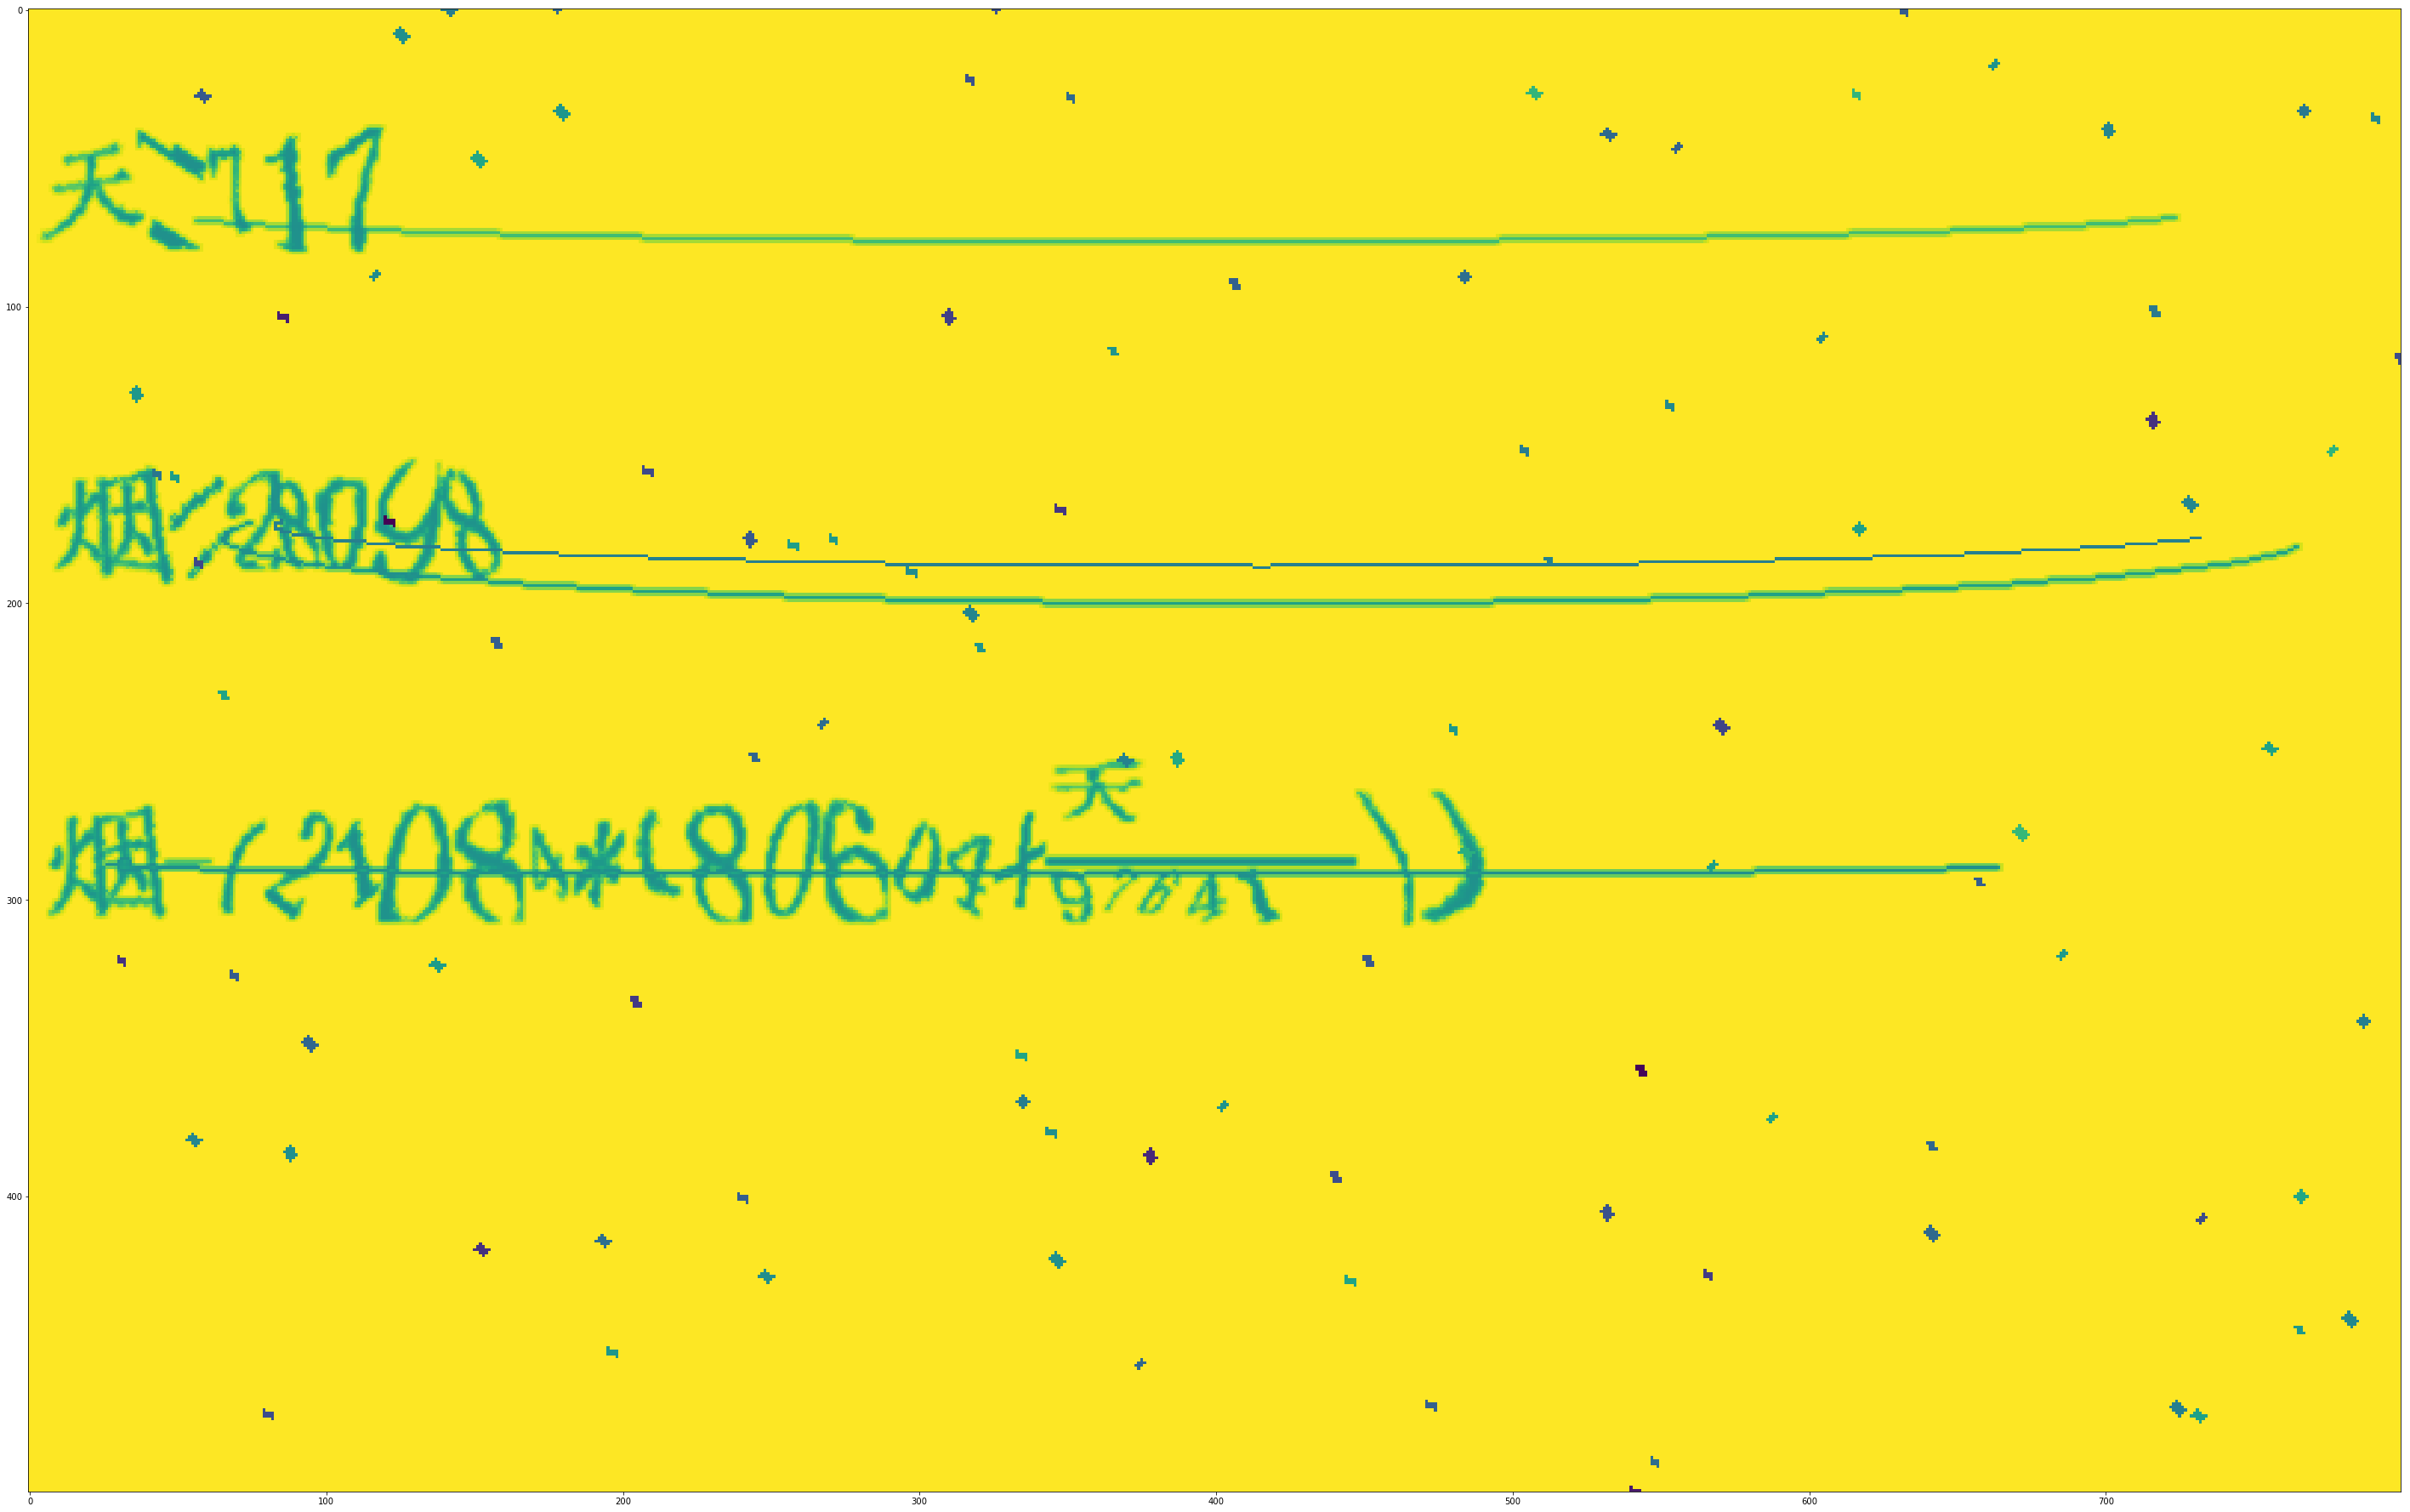

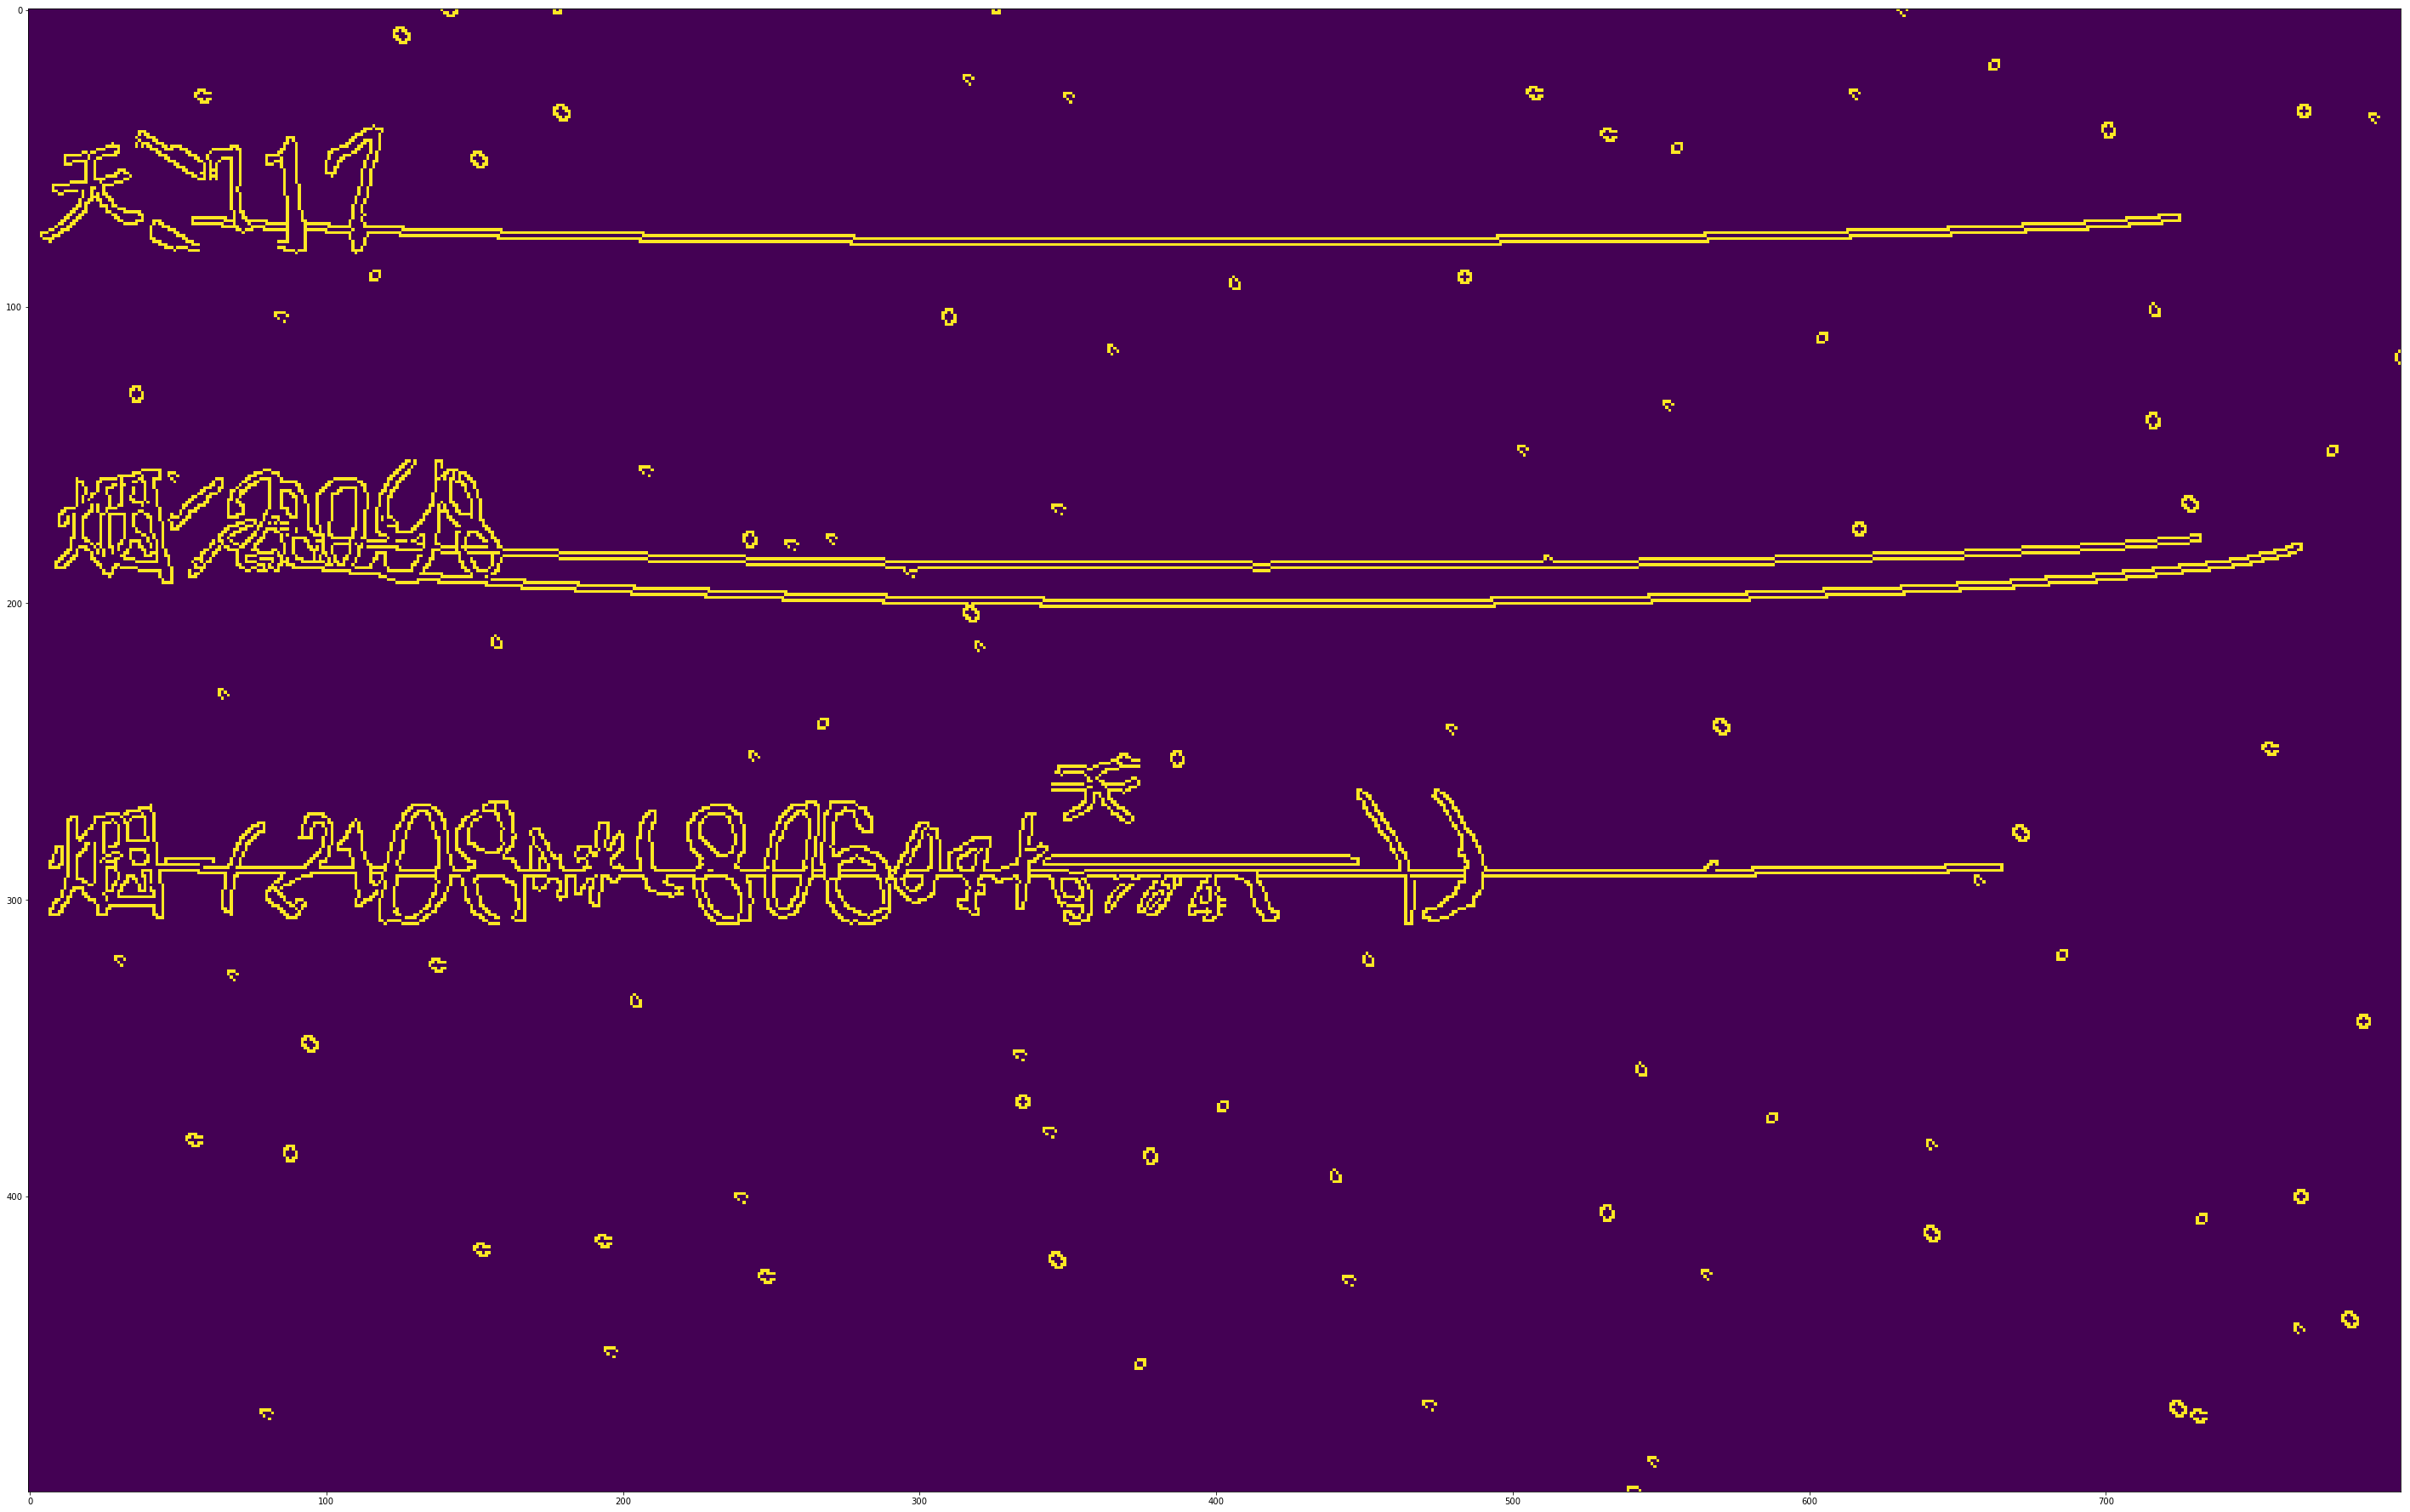

In [10]:
import cv2
import numpy as np

img = cv2.imread('data/baidu/image_contest_level_2/34903.png' ,0)

f = plt.figure(figsize=(50,50), frameon=True)
plt.imshow(img)


edges = cv2.Canny(img,50,200)

f = plt.figure(figsize=(50,50), frameon=True)
plt.imshow(edges)



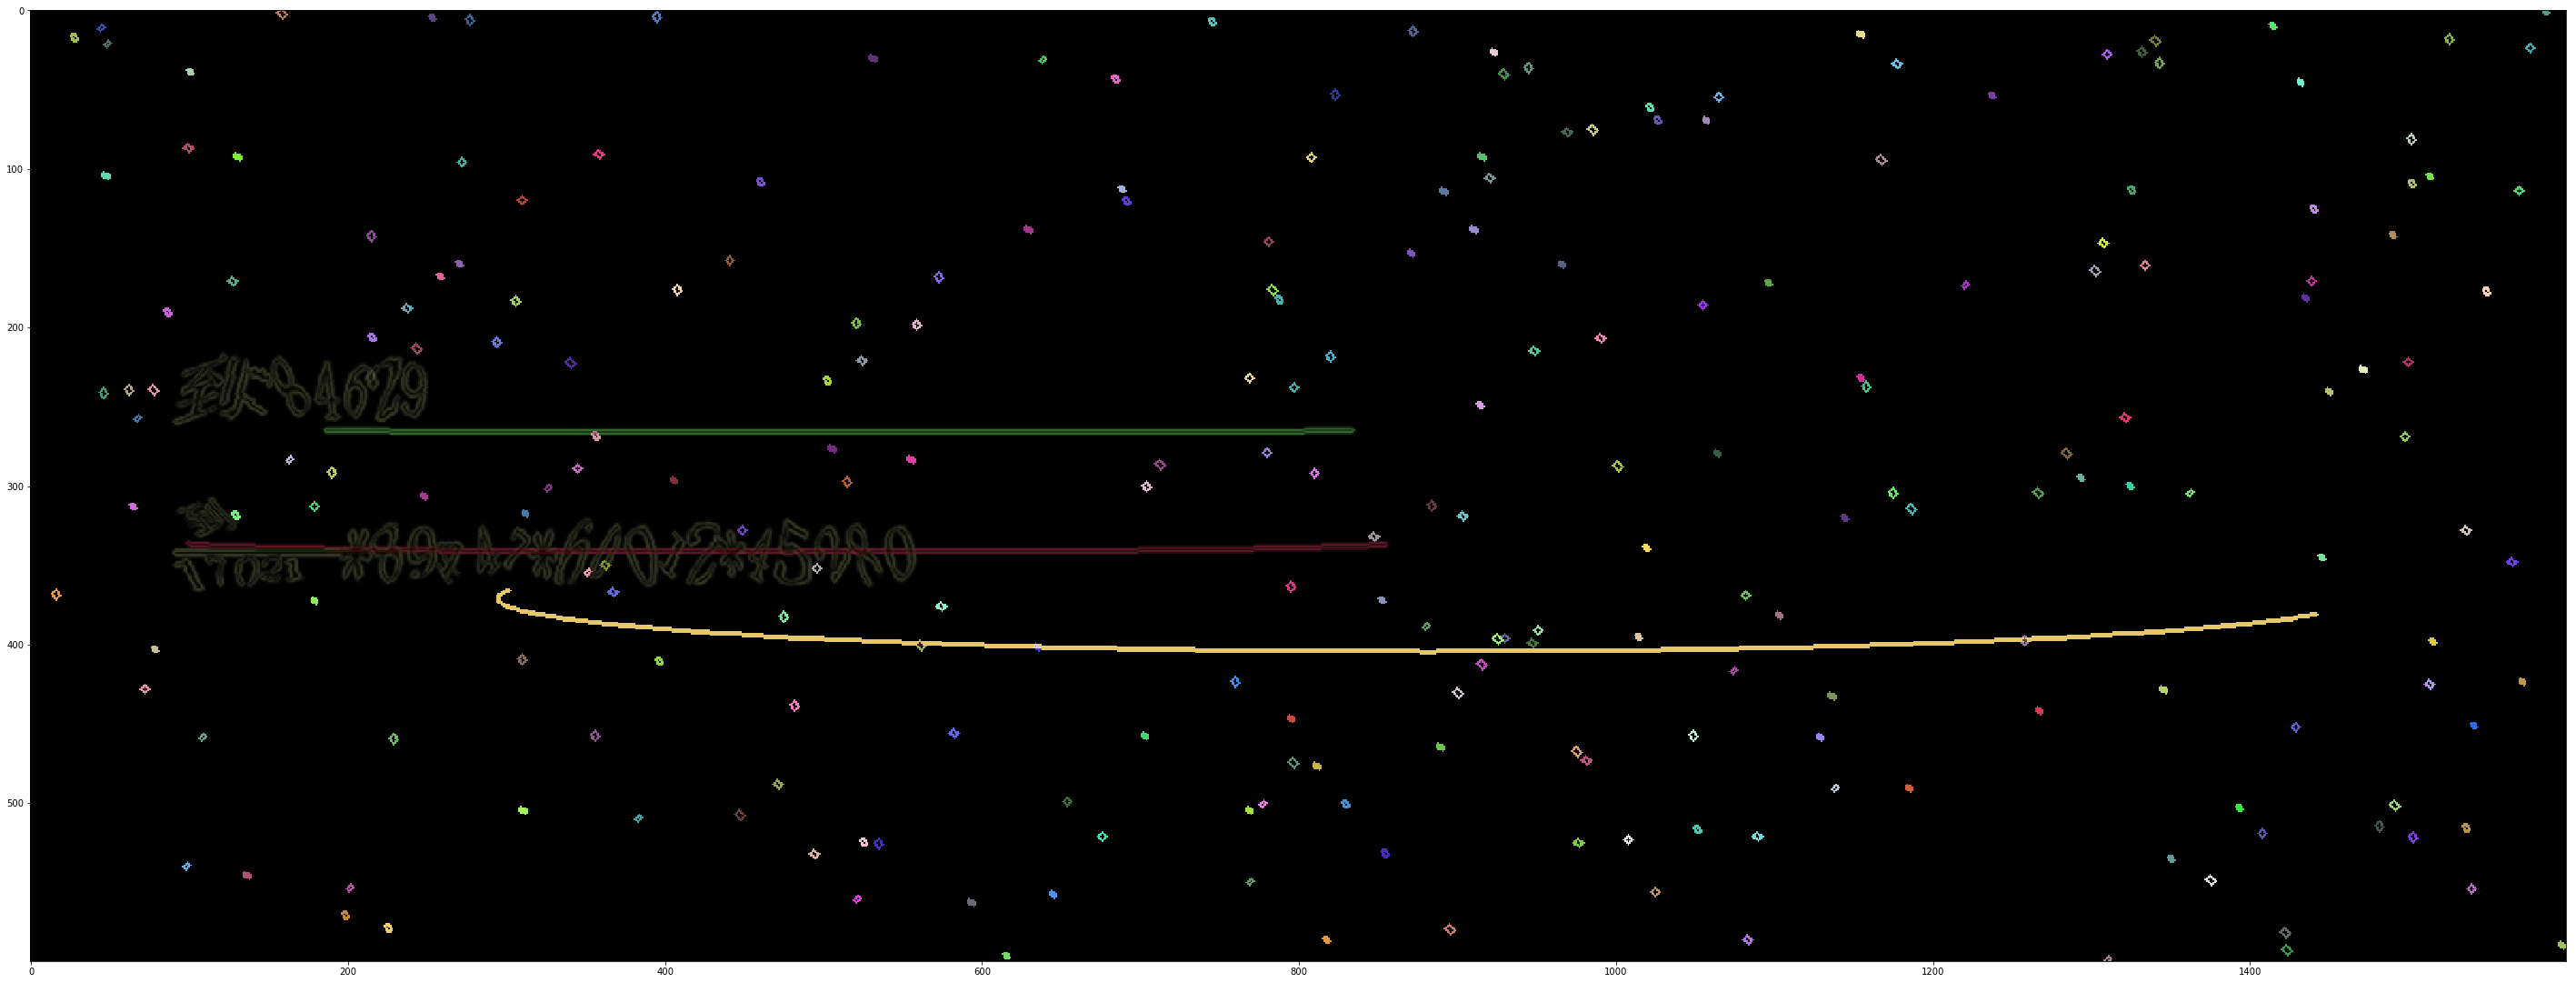

In [11]:
img = cv2.imread('data/baidu/image_contest_level_2/34901.png')
b,g,r = cv2.split(img)           # get b,g,r
rgb_img = cv2.merge([r,g,b])     # switch it to rgb

morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
grad = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, morphKernel)

f = plt.figure(figsize=(50,50), frameon=True)
plt.imshow(grad)

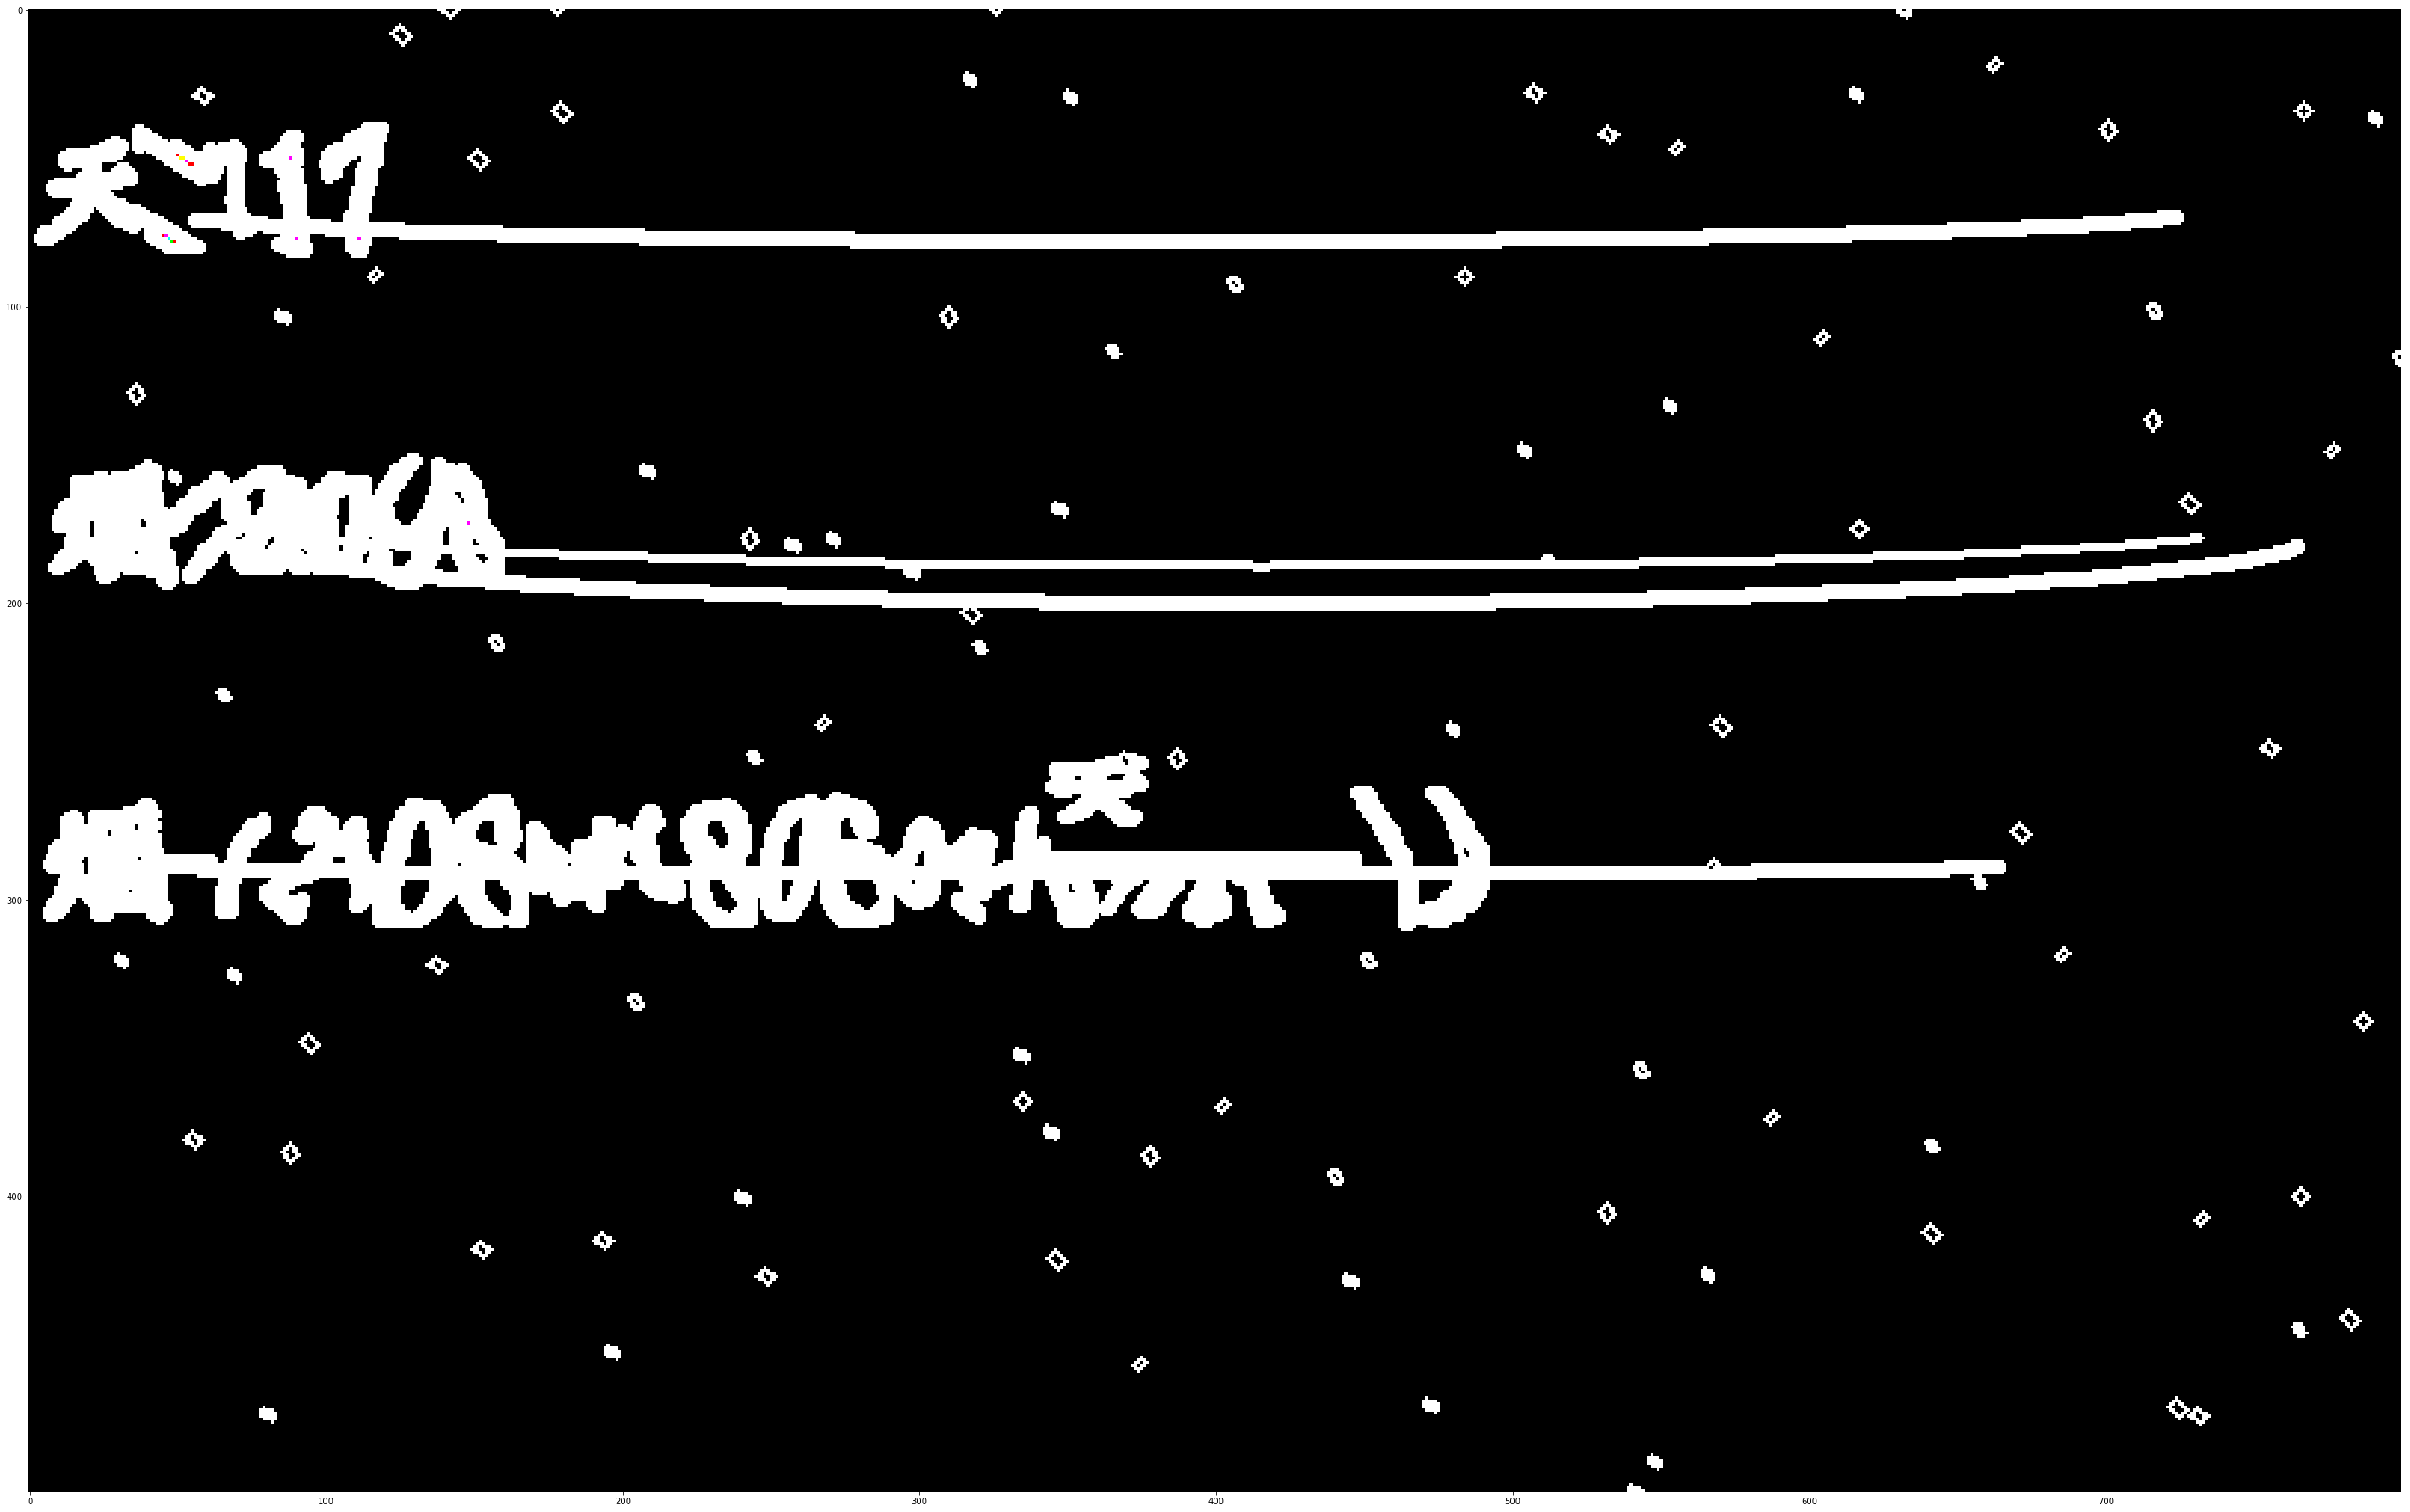

In [56]:
ret, bw = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY)
f = plt.figure(figsize=(50,50), frameon=True)
plt.imshow(bw)

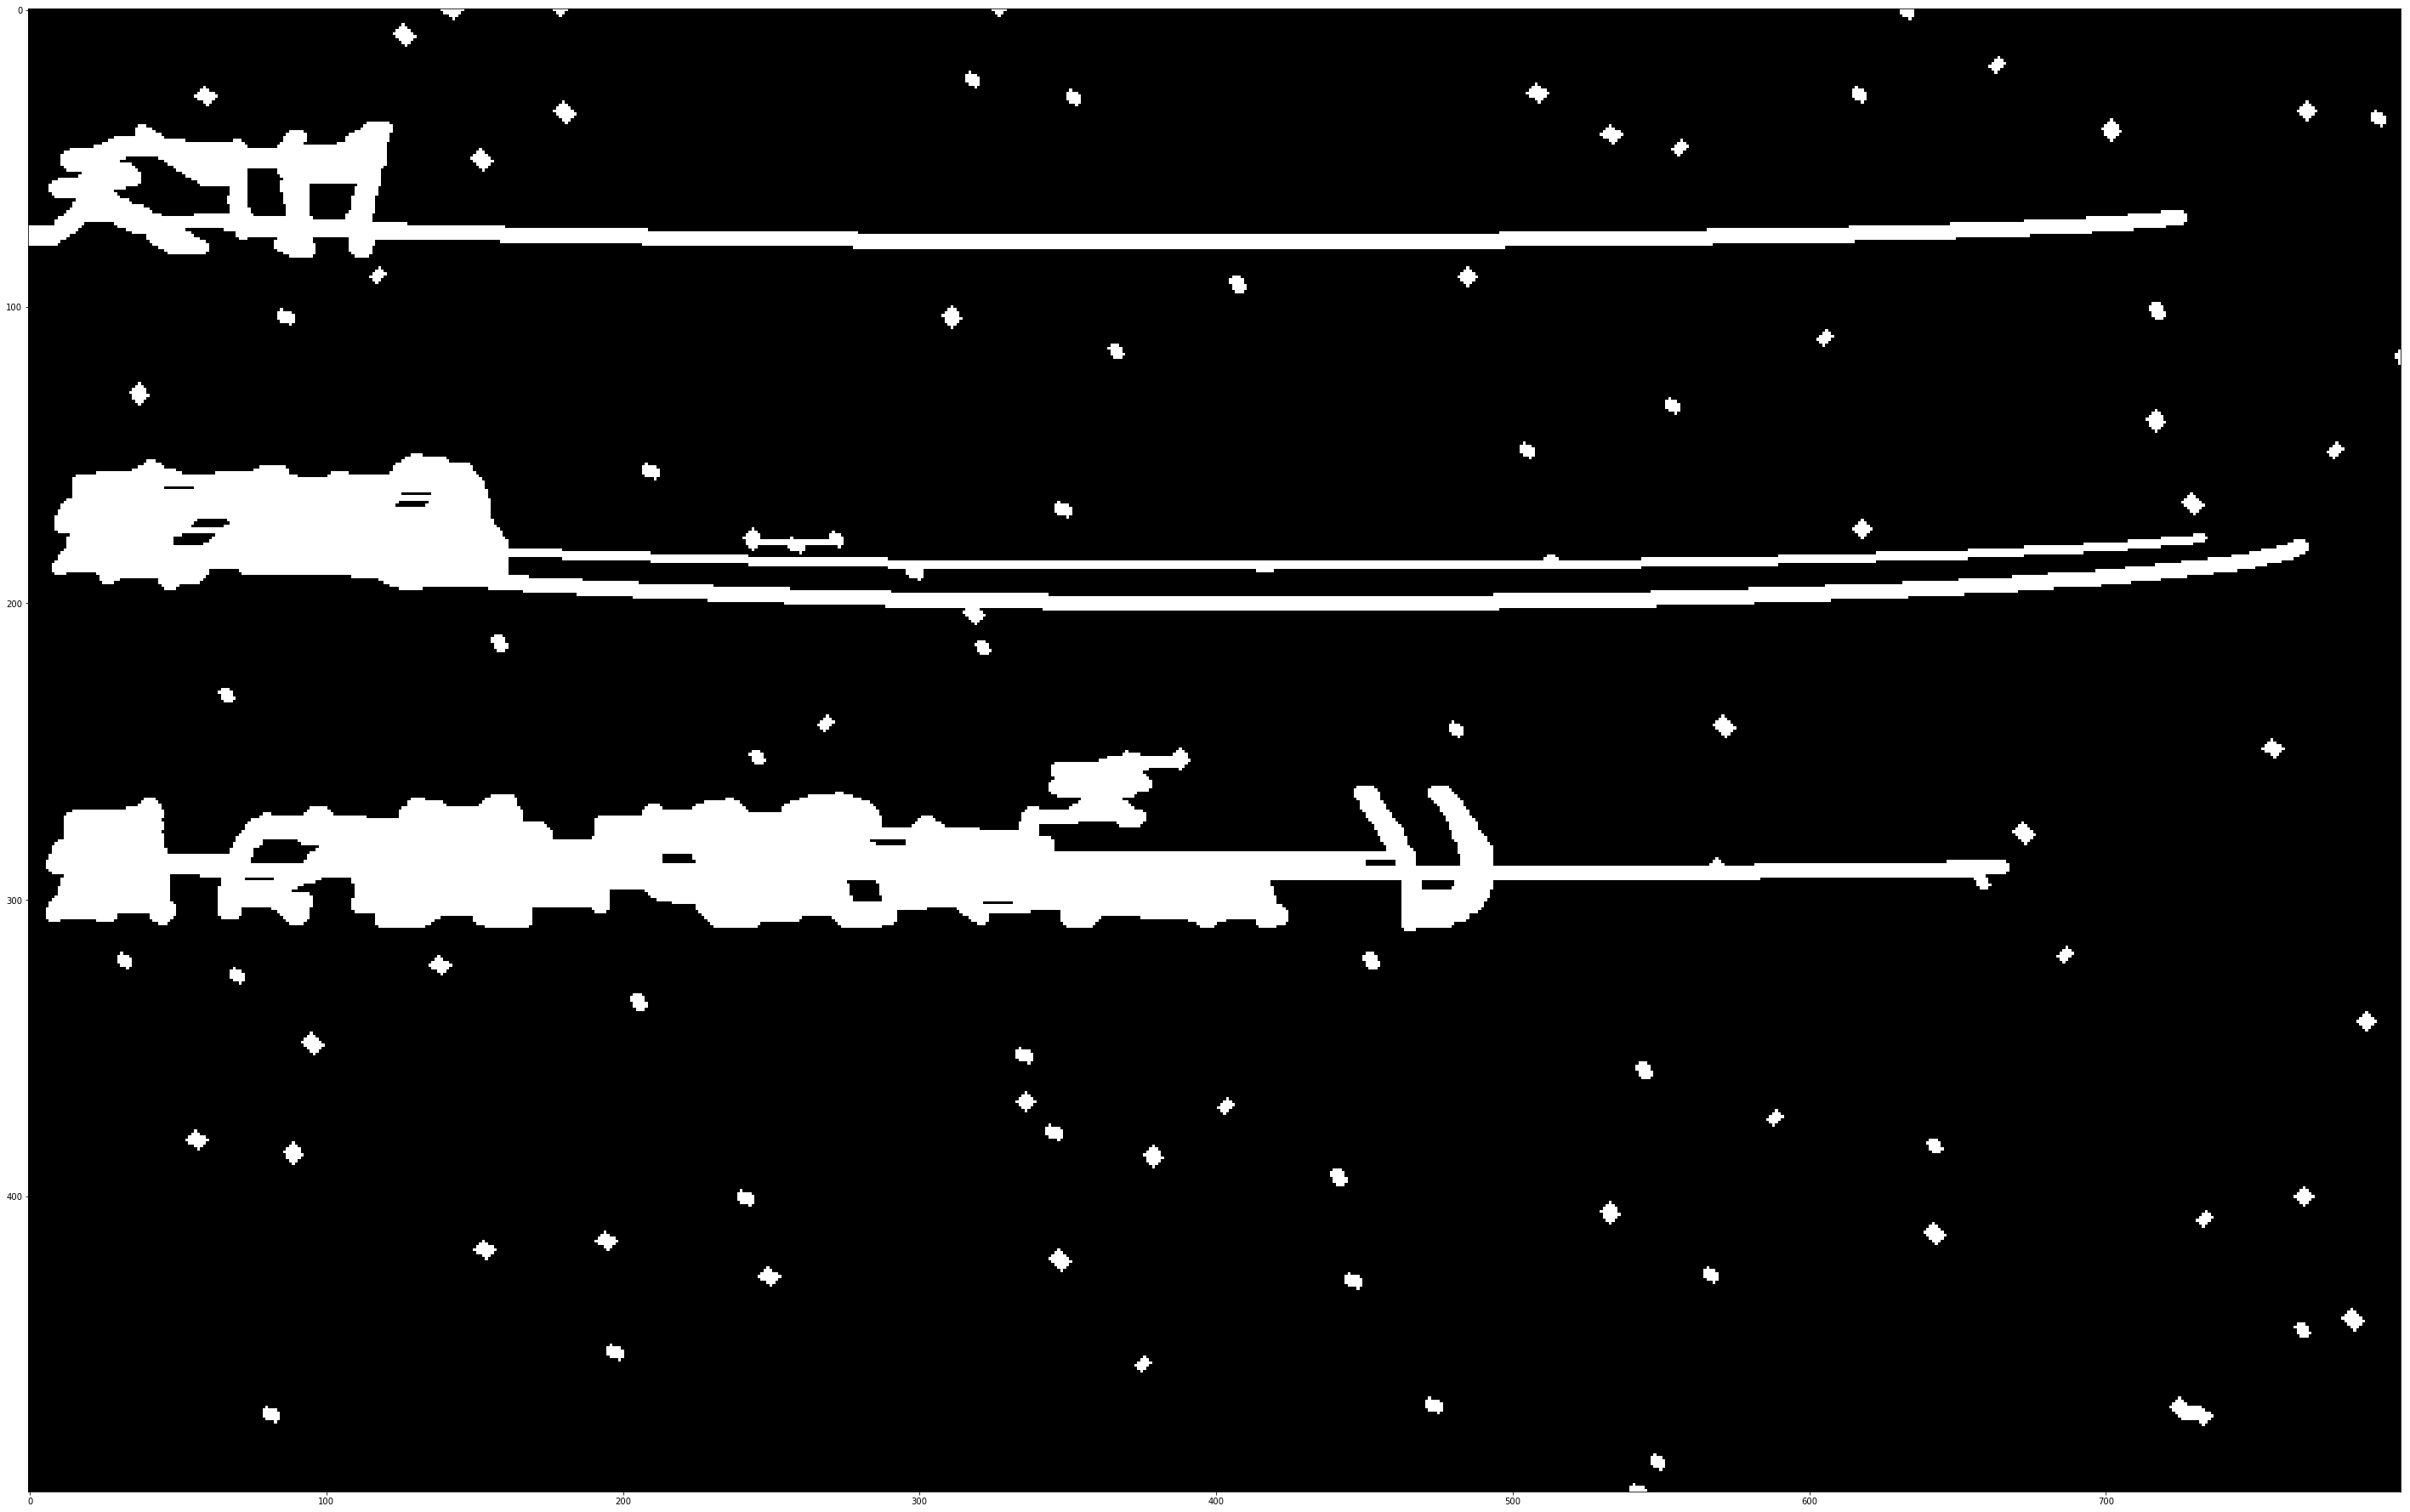

In [57]:
morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,1))
closed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, morphKernel)

f = plt.figure(figsize=(50,50), frameon=True)
plt.imshow(closed)

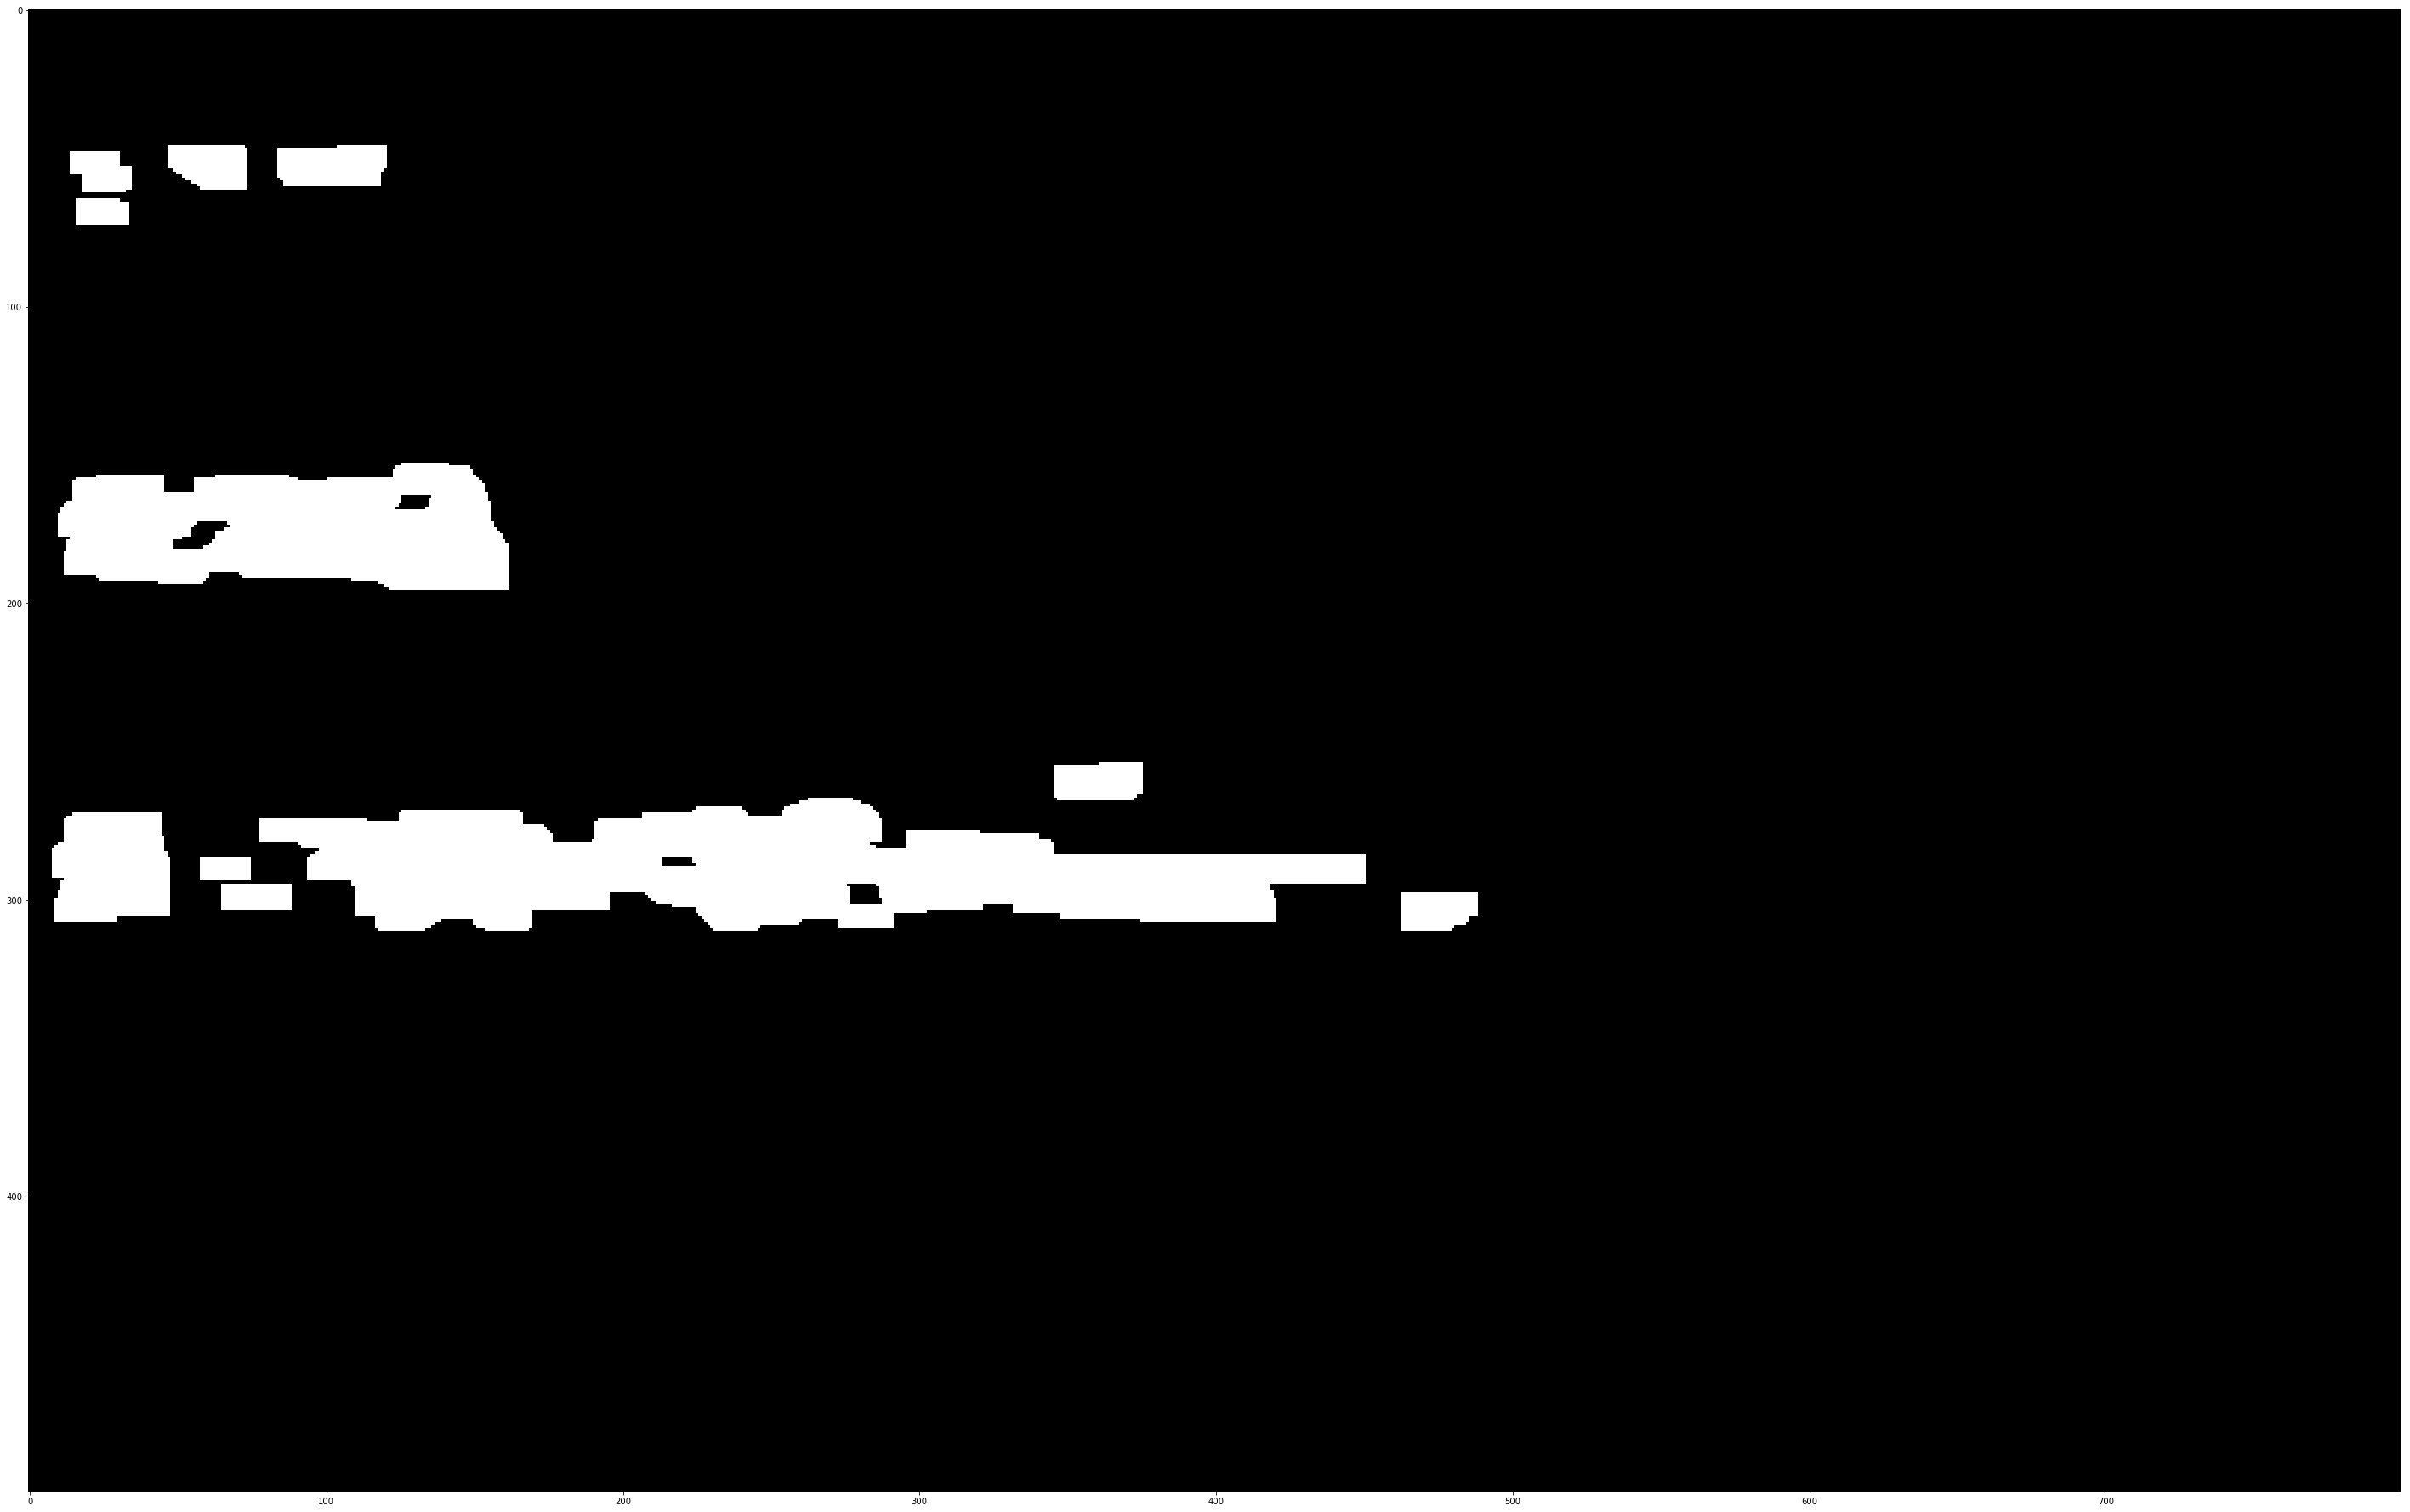

In [66]:
morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,8))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, morphKernel)

f = plt.figure(figsize=(50,50), frameon=True)
plt.imshow(opened)

In [24]:
imgray = cv2.cvtColor(opened, cv2.COLOR_BGR2GRAY)
contours2, hierarchy = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [499]:
areas = []
found_rects = []
for c in contours2:
    x, y, width, height = cv2.boundingRect(c)
    area = width*height
    areas.append(area)
    found_rects.append([x, y, width, height]) 

In [2]:
def groupOverlapRect(a, b):
    ax,ay,aw,ah=a
    bx, by, bw, bh=b
    
    xmin = min([ax, bx])
    xmax = max([ax+aw, bx+bw])
    
    ymin = min([ay, by])
    ymax = max([ay+ah, by+bh])
    
    lt = (xmin, ymin)
    w = xmax-xmin
    h = ymax - ymin
    
    return (xmin, ymin, w, h)
    

In [3]:
def isRectOverlap(a, b):
    ax,ay,aw,ah=a
    bx, by, bw, bh=b

    return (ay < by + bh and by+bh < ay + ah) or abs(ay-by) <= 40

In [4]:
def doGroupRects(rects):
    assert(len(rects)>0)
    out = []
    previous = rects[0]
    for i in xrange(1, len(rects)):
        overlap = isRectOverlap(previous, rects[i])
        if overlap:
            previous = groupOverlapRect(previous, rects[i])
        else:
            out.append(previous)
            previous = rects[i]
    out.append(previous)
    return out

In [5]:
def draw_ract(img, rects):
    v = img.copy()
    plt.figure(figsize=(20,20), frameon=True)
    for r in doGroupRects(rects):
        x,y,w,h=r
        cv2.rectangle(v,(x,y),(x+w,y+h),(0,255,255),2)
        plt.imshow(v)

In [6]:
def refinedhelper(a, rects):
    #处理特殊情况   其中一个向左边严重突出
    #向右严重突出不用处理  直接向右截断
    if len(rects)==3:
        #最下面
        refinedhelper([0,1,2], rects)
        #中间
        refinedhelper([1,0,2], rects)
        #第一个
        refinedhelper([2,0,1], rects)
    
    if rects[a[0]][0] - rects[a[1]][0] < -100 and abs(rects[a[1]][0] - rects[a[2]][0]) < 20:
            rects[a[0]] = (rects[a[1]][0], rects[a[0]][1], rects[a[0]][2], rects[a[0]][3]) 

In [7]:
def find_contour_rects(img):
   
    morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    grad = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, morphKernel)

    ret, bw = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY)
    
    morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,1))
    closed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, morphKernel)

    morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,8))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, morphKernel)
    
    imgray = cv2.cvtColor(opened, cv2.COLOR_BGR2GRAY)
    contours2, hierarchy = cv2.findContours(imgray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    found_rects = []
    for c in contours2:
        x, y, width, height = cv2.boundingRect(c)
        found_rects.append([x, y, width, height]) 
    
    return found_rects
    

In [8]:
def removeTooSmallContour(rects):
    out = []
    for i, rec in enumerate(rects):
        x,y,w,h = rec
        #忽略区域过小的box
        if w>10 and h>10:
             out.append([x,y,w,h])
    return out

In [9]:
def removeTooSmall(rects):
    out = []
    for i, rec in enumerate(rects):
        x,y,w,h = rec
        #忽略区域过小的box
        if w>20 or h>20:
             out.append([x,y,w,h])
    return out

In [10]:
def refinedRects(rects):
    #600*60
    out = []
               
    for i, rec in enumerate(rects):
        x,y,w,h = rec
            
        #是最下面的那个复杂表达式  把锁定范围加大
        if i==0:
            x = x-50
            y = y-20
            h = h+30
            if w < 450: 
                w=600 
            else:
                w = w+100
             #处理过长的
            if w > 600: w = 600
        else:
            x = x-30
            y = y-10
            h = h+20
            w = w+50
            if w>300: w=300
        if y<0: y=0
        if x<0: x=0
        
        out.append([x,y,w,h])
    return out

In [11]:
def refined_contour_rects(rects):
    filter_extrem_small = removeTooSmallContour(rects)
    group_rects = doGroupRects(filter_extrem_small)
    filtered_rects = removeTooSmall(group_rects)
    refined_rects = refinedRects(filtered_rects)    
    return refined_rects

In [12]:
def cut_and_save_image(path_prefix, img, rects):
    for i, r in enumerate(rects):
        cv2.imwrite('{}-{}-{}.png'.format(path_prefix, str(i+1), len(rects)), 
                    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]])

In [13]:
def padding_img(img):
    h,w,ch = np.array(img).shape
    bottom = 0
    right = 0
    if h<90:
        bottom  = 90 -h 
    if w<600:
        right = 600 - w
    if bottom > 0 or right > 0:
        return cv2.copyMakeBorder(img,0,bottom,0,right,cv2.BORDER_CONSTANT)
    return img

In [14]:
%mkdir data/baidu/image_contest_level_2_validate_processed/

In [ ]:
import cv2
#切图
img_dir = 'data/baidu/image_contest_level_2_validate/'
processed_img_dir = 'data/baidu/image_contest_level_2_validate_processed/'
from os import listdir
from os.path import isfile, join
files = listdir("data/baidu/image_contest_level_2_validate")
all_rects = []
all_length = []
for i in range(100000):
    img = cv2.imread(img_dir+str(i)+'.png')
    contour_rects = find_contour_rects(img)
    rects = refined_contour_rects(contour_rects)
    
    #draw_ract(img, rects)
    
    all_rects.append(rects)
    all_length.append(len(rects))
    
    cut_and_save_image(processed_img_dir+str(i), img, rects)

    if i%10000 == 0:
        print(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [82]:
#填充图片达到固定大小
train_path = 'data/baidu/image_contest_level_2_train/'
files = listdir(processed_img_dir)
for f in files:
    img = cv2.imread(processed_img_dir+f)
    nimg = padding_img(img)
    cv2.imwrite(train_path+f, nimg)

In [17]:
for f in files[:10]:
    img = image.load_img(train_path+f)
    plt.figure(figsize=(20,20), frameon=True)
    plt.imshow(cv2.resize(img, (300, 45)) )
    
    

IOError: [Errno 2] No such file or directory: 'data/baidu/image_contest_level_2_validate_processed/24106.png'

In [31]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    result = parts[1]
    label_exp_num_length.append(len(exprs.split(';')))

In [69]:
removeTooSmall([(8, 254, 481, 57), [10, 153, 152, 43], (14, 46, 107, 16)])

[[8, 254, 481, 57], [10, 153, 152, 43]]

[[0, 308, 600, 46], [3, 277, 300, 79], [0, 170, 188, 54], [0, 39, 202, 63]]


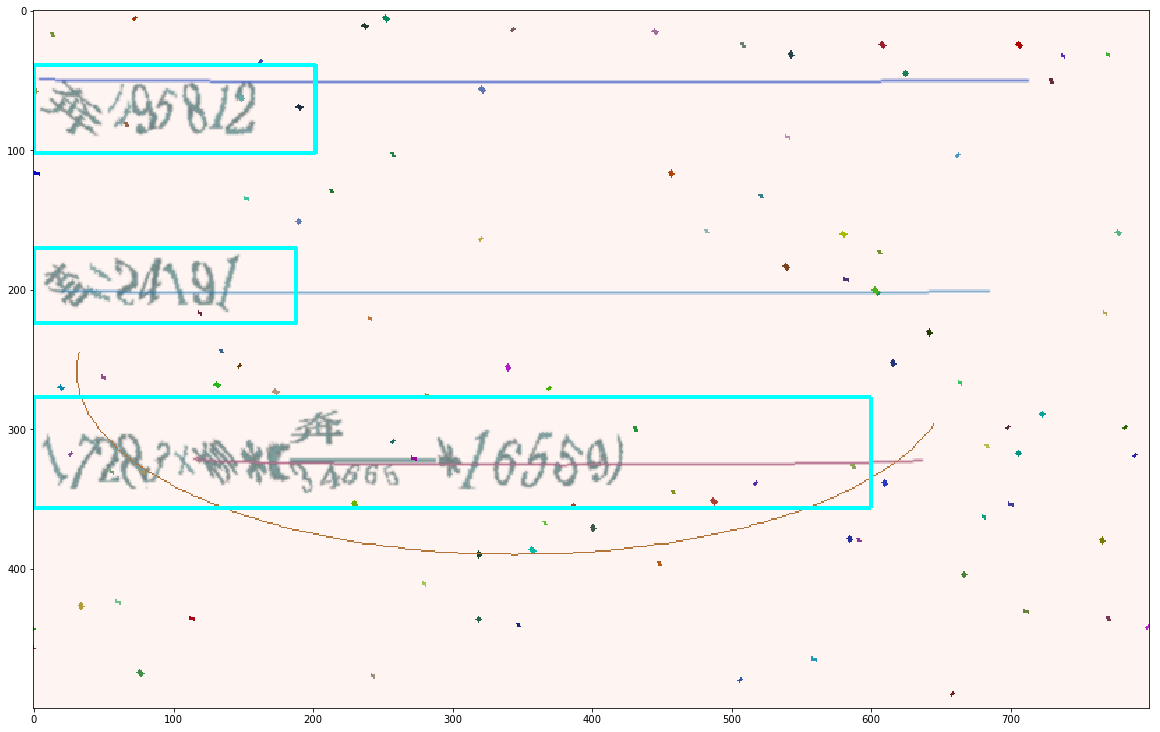

In [49]:

#to_search = np.where(all_length==4)[0] 
to_search = [96884]
for f in to_search:
    img = cv2.imread(img_dir+str(f)+'.png')
    contour_rects = find_contour_rects(img)
    rects = refined_contour_rects(contour_rects)
    print(rects)
    draw_ract(img, rects)
    
    cut_and_save_image(processed_img_dir+str(34903), img, rects)

In [32]:
len(label_exp_num_length)

100000

In [715]:
label_exp_num_length[-10:]

[2, 3, 3, 2, 3, 2, 2, 2, 3, 3]

In [18]:
all_length[-10:]

[3, 3, 2, 2, 3, 2, 2, 3, 3, 3]

In [33]:
np.allclose(all_length, label_exp_num_length)

False

In [19]:
all_box = np.array(all_rects)

In [20]:
all_box = np.concatenate(all_box, axis=0)

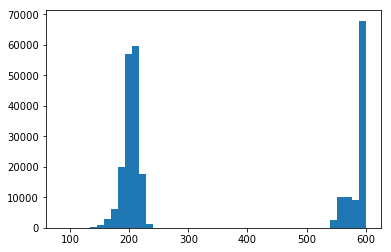

In [21]:
plt.hist(all_box[:, 2], bins='auto')  # arguments are passed to np.histogram
plt.show()

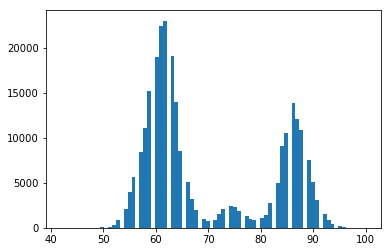

In [22]:
plt.hist(all_box[:, 3], bins='auto')  # arguments are passed to np.histogram
plt.show()

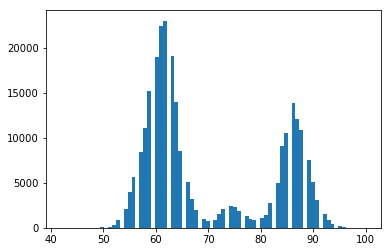

In [23]:
plt.hist(all_box[:, 3], bins='auto')  # arguments are passed to np.histogram
plt.show()

In [24]:
(all_box[:,2]).min(), (all_box[:,2]).max()

(85, 600)

In [25]:
(all_box[:,3]).min(), (all_box[:,3]).max()

(42, 100)

In [26]:
def test_found_width(w):
    for i, rects in enumerate(all_rects):
        for j, rect in enumerate(rects):
            if rect[2] == w:
                return i,j, len(rects)
    return None

In [27]:
def test_found_height(h):
    for i, rects in enumerate(all_rects):
        for j, rect in enumerate(rects):
            if rect[3] == h:
                return i,j, len(rects)
    return None

In [28]:
def test_show_height_img(h):
    a = test_found_height(h)
    if a == None: return
    img = cv2.imread(processed_img_dir+'{}-{}-{}.png'.format(a[0], a[1]+1, a[2]))
    plt.figure(figsize=(20,20), frameon=True)
    plt.imshow(img)
    print(raw_label_list[a[0]])

In [29]:
def test_show_width_img(w):
    a = test_found_width(w)
    if a == None: return
    img = cv2.imread(processed_img_dir+'{}-{}-{}.png'.format(a[0], a[1]+1, a[2]))
    plt.figure(figsize=(20,20), frameon=True)
    plt.imshow(img)
    #print(raw_label_list[a[0]])

NameError: global name 'raw_label_list' is not defined

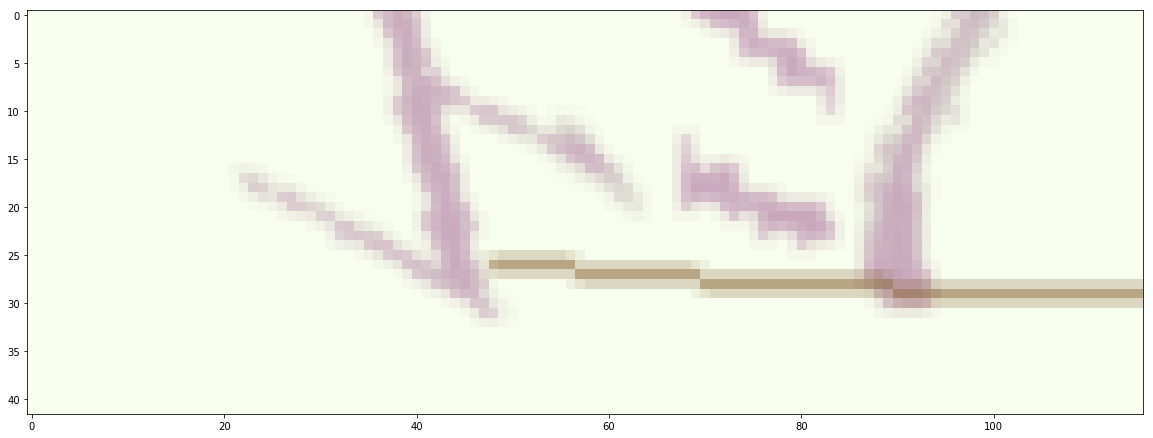

In [30]:
test_show_height_img(42)

水=98439;21399+(49969+1634)*水/38854 152138.37


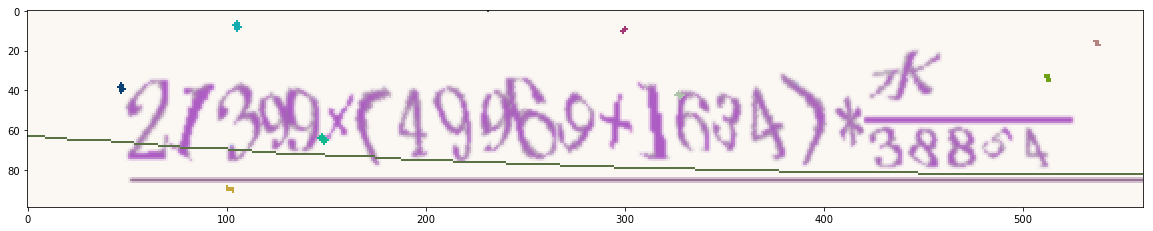

In [47]:
test_show_height_img(99)

不=8;深=82111;深-(不/85734+70800*95915) -6790699889.00


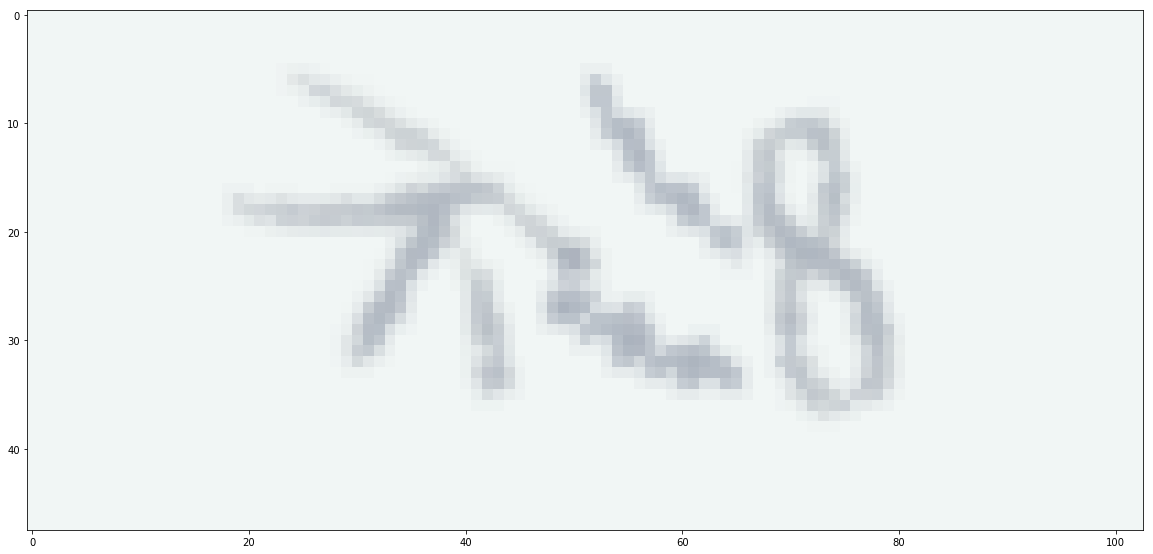

In [50]:
test_show_width_img(103)

In [ ]:
img = cv2.imread('data/baidu/test-0-3-3.png')
plt.figure(figsize=(20,20), frameon=True)
plt.imshow(img)

resized = cv2.resize(img, (300, 50), interpolation = cv2.INTER_LINEAR)
plt.figure(figsize=(20,20), frameon=True)
plt.imshow(resized)

nimg = padding_img(img)
plt.figure(figsize=(20,20), frameon=True)
plt.imshow(nimg)

In [831]:
np.array(img).shape

(60, 194, 3)

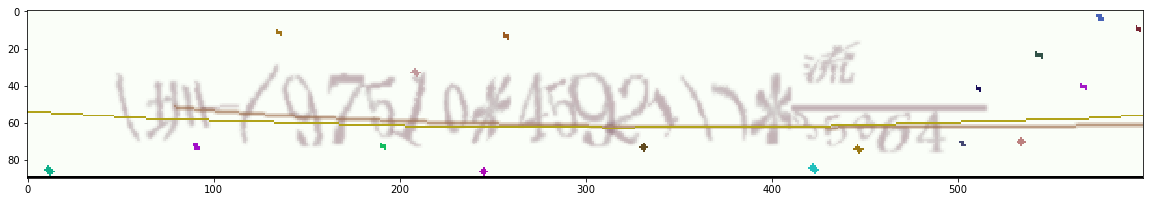

In [845]:
nimg = padding_img(img)
plt.figure(figsize=(20,20), frameon=True)
plt.imshow(nimg)

In [864]:
len(all_length)

100000

In [865]:
all_length[:5]

[3, 3, 2, 2, 3]

In [31]:
save_array('data/baidu/validate_label_exp_num.data', all_length)

In [45]:
np.where(np.array(all_length)==4)[0]

array([96884])

In [ ]:
Image.open('data/baidu/')